### Synthetic Inversion Test

***

In [1]:
# %matplotlib widget
import sys, os, importlib
package_path = os.path.abspath('..')    
if package_path not in sys.path:
    sys.path.append(package_path)
from package import functions as fn
from package import model as rm
from package import optimizer as opt
from package import plots
import numpy as np
from obspy.taup import TauPyModel

Seed: 2025
Original params:  [315.  90. 180.]


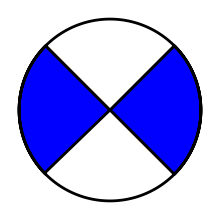

In [2]:
seed = 2025
np.random.seed(seed)
print(f'Seed: {seed}')

# create random array for t, normalised to 1
t = fn.unit_vec(np.random.rand(3))

# create random array for p, normalised to 1
direc = fn.unit_vec(np.random.rand(3))
p = fn.starting_direc(t, direc)

### NOTE OTHER MECHANISMS FOR COMPARISON ###
# t, p = fn.k_hat, fn.i_hat
# t, p = fn.unit_vec(fn.i_hat + fn.j_hat), \
#     fn.unit_vec(fn.j_hat - fn.i_hat)
t, p = fn.i_hat, fn.j_hat

# get true params for synthetic test
true_params = fn.tp2sdr(t, p, True)[0]
print('Original params: ', true_params)

# plot corresponding beachball
beachball = fn.beachball(true_params)

# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model
# model = TauPyModel(model='iasp...')
hdepth = 15  # km - assumed quake depth
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer
p_arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P'])
s_arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['S'])
takeoff_angles = [p_arrivals[0].takeoff_angle, s_arrivals[0].takeoff_angle]

# for other depths, extract velocities from lookup table
velocities = np.array([5.8000, 3.4600])

In [3]:
# initialize model
radiation_model = rm.RadiationModel(np.deg2rad(azimuth),
                                    takeoff_angles, velocities)

model_Ao = radiation_model(np.deg2rad(true_params), set_Ao=True,
                           return_A=True)

# tune hyperparameters
config = opt.get_config()

# multistart optimization
num_starts = 50
starts = fn.random_params(num_starts)

radiation_model.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_starts}')
    opt.minimize(radiation_model, config, start)
    
print(f'Convergence rate: {radiation_model.get_convergence_rate():.0f}%')

Run 0 of 50
Run 10 of 50
Run 20 of 50
Run 30 of 50
Run 40 of 50
Convergence rate: 96%


Constrained axis: P
Optimal parameters: [101.69642252  79.25904441  14.67132334]
Search error: 0.7535351852148519 degrees


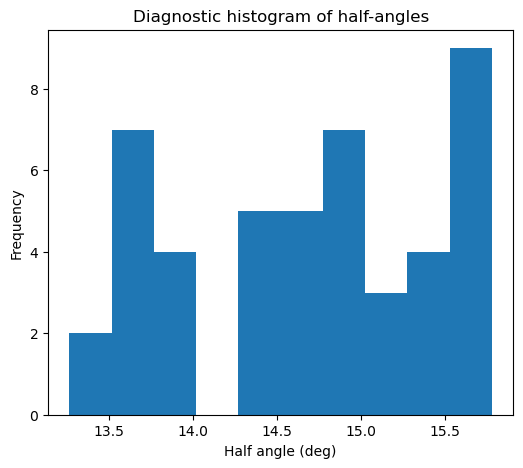

In [4]:
# the dense parameterization in one space
params, error, position = radiation_model.get_optimal_parameters(z_threshold=2)
name = 'T' if position == 0 else 'P'

print(f'Constrained axis: {name}')
print(f'Optimal parameters: {np.rad2deg(params)}')
print(f'Search error: {np.rad2deg(error)} degrees')

plots.half_angles(radiation_model, bins=10)

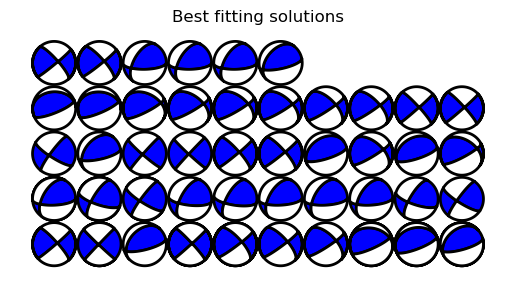

In [5]:
# best-fitting mechanisms
plots.beachballs(radiation_model, central=False, order_by='strike')

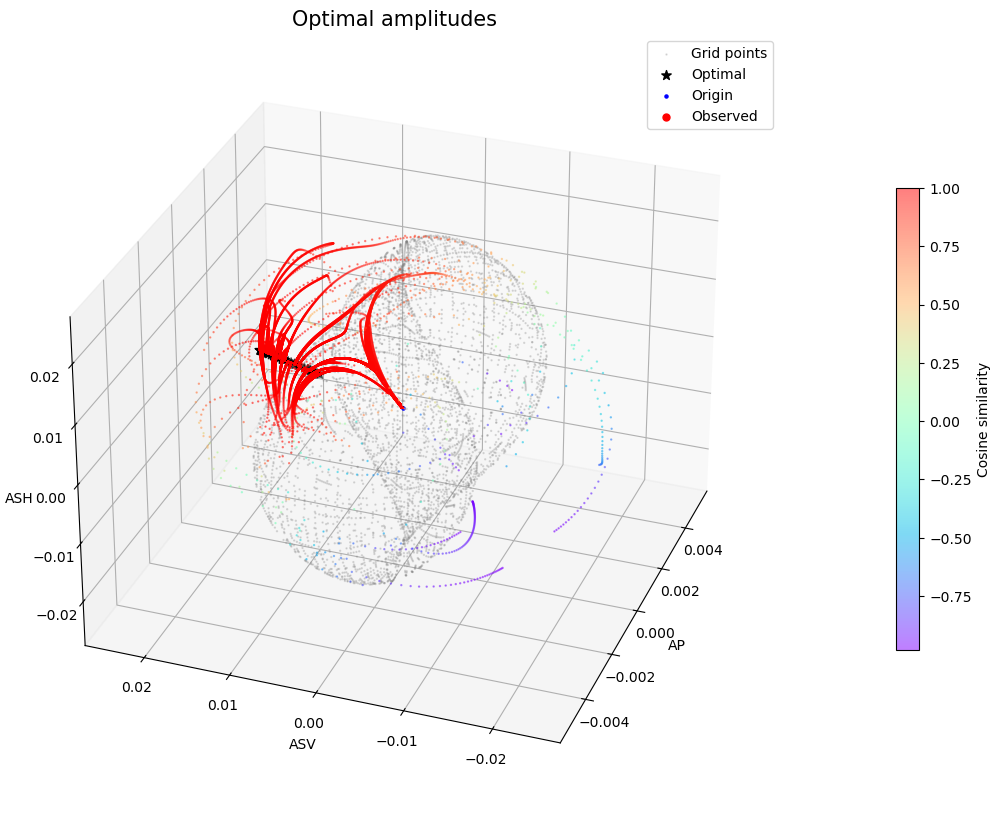

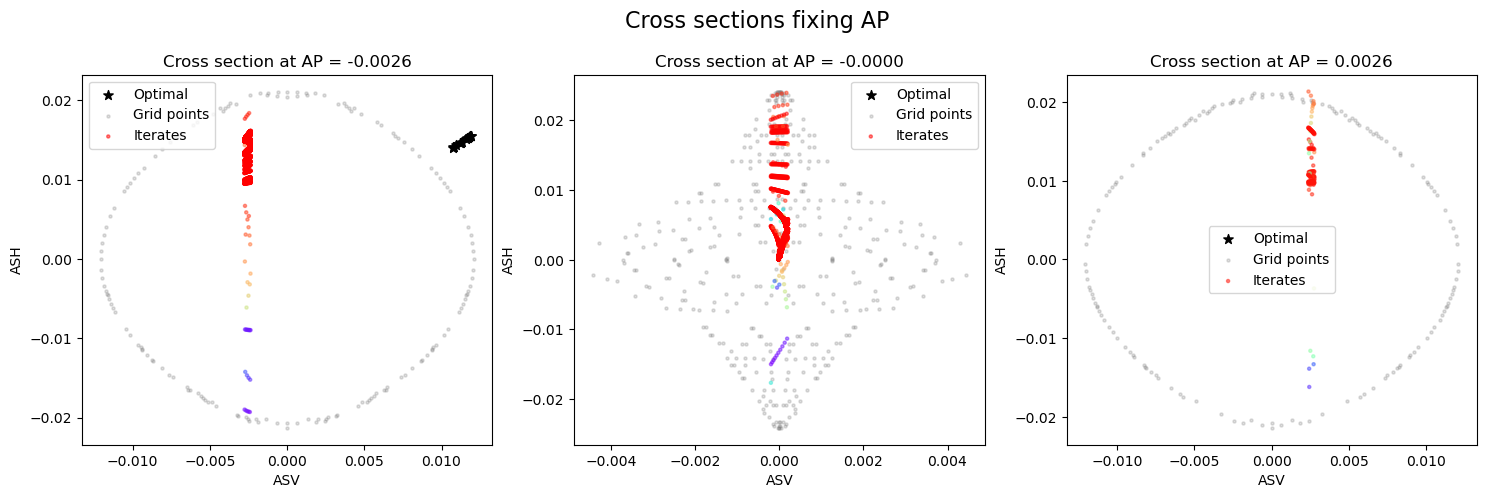

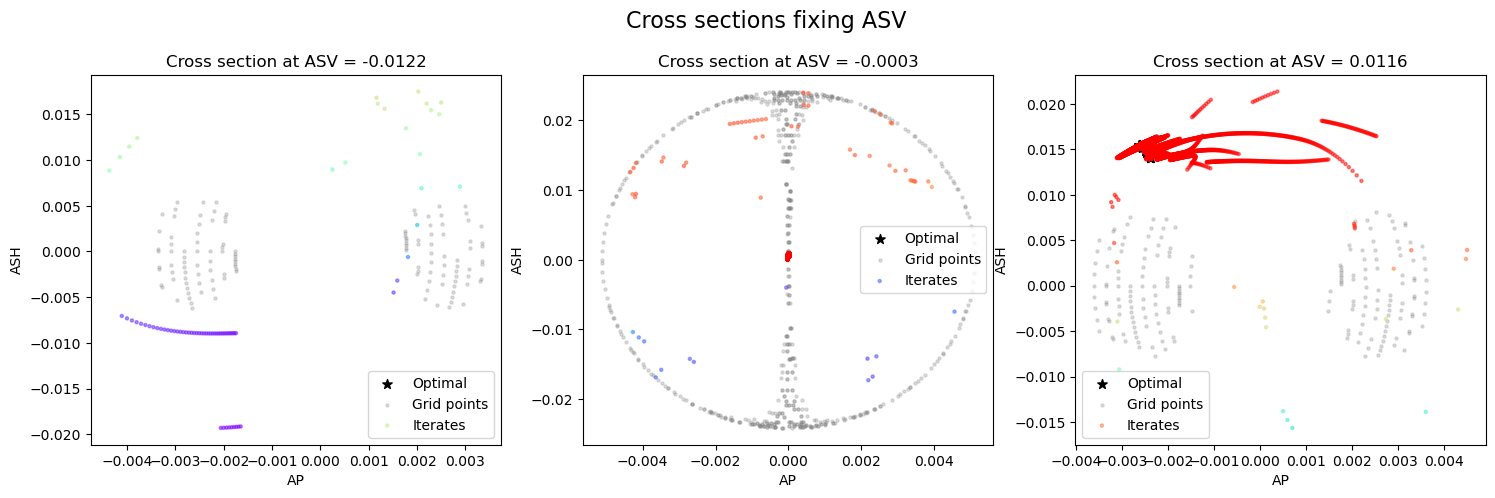

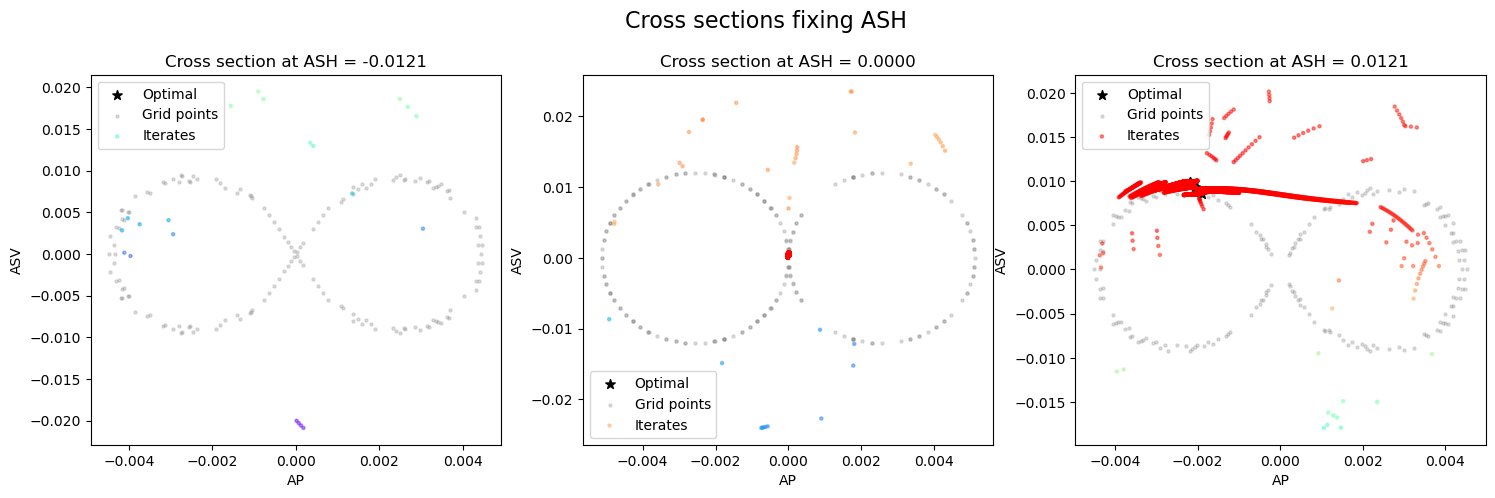

In [6]:
# fix parameters (mechanism), vary hyperparameters (station location)
radiation_model.reset_grid_amplitudes()
radiation_model.set_grid_amplitudes(3, random=False, fix_params=True)
plots.amplitudes(radiation_model, azim=200, elev=30, s=50, alpha=0.5,
                 iterates=True, grid=True, cross_section=[3,3,3],
                 eps_factor=2e-2, optimal=True, observed=True)

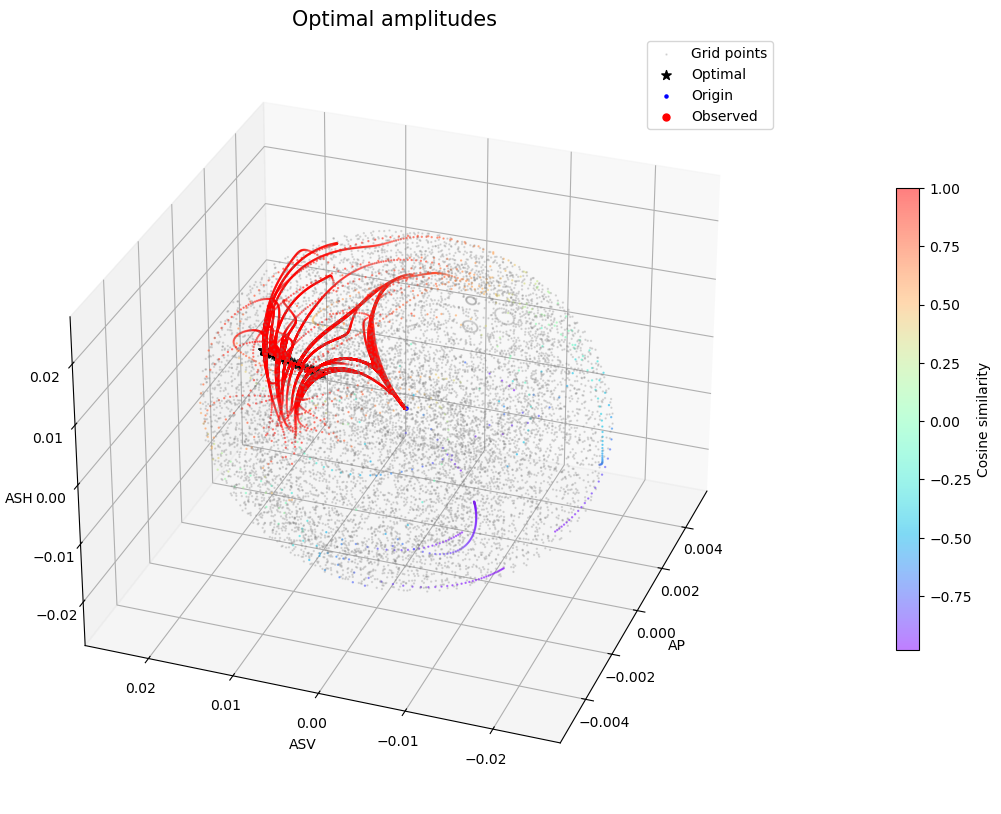

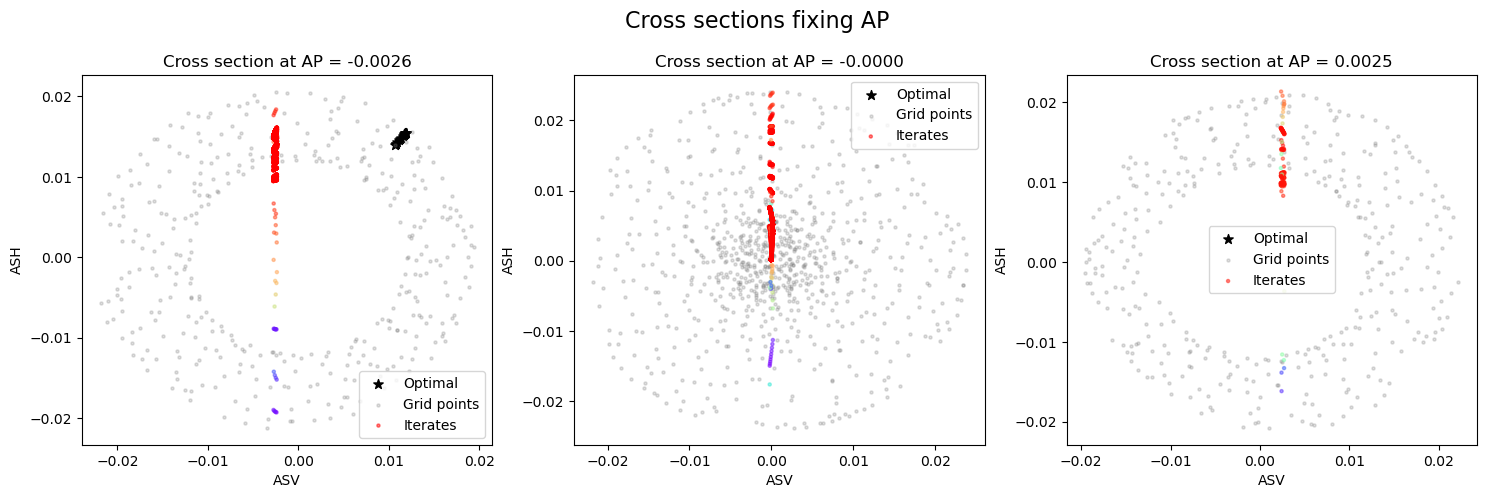

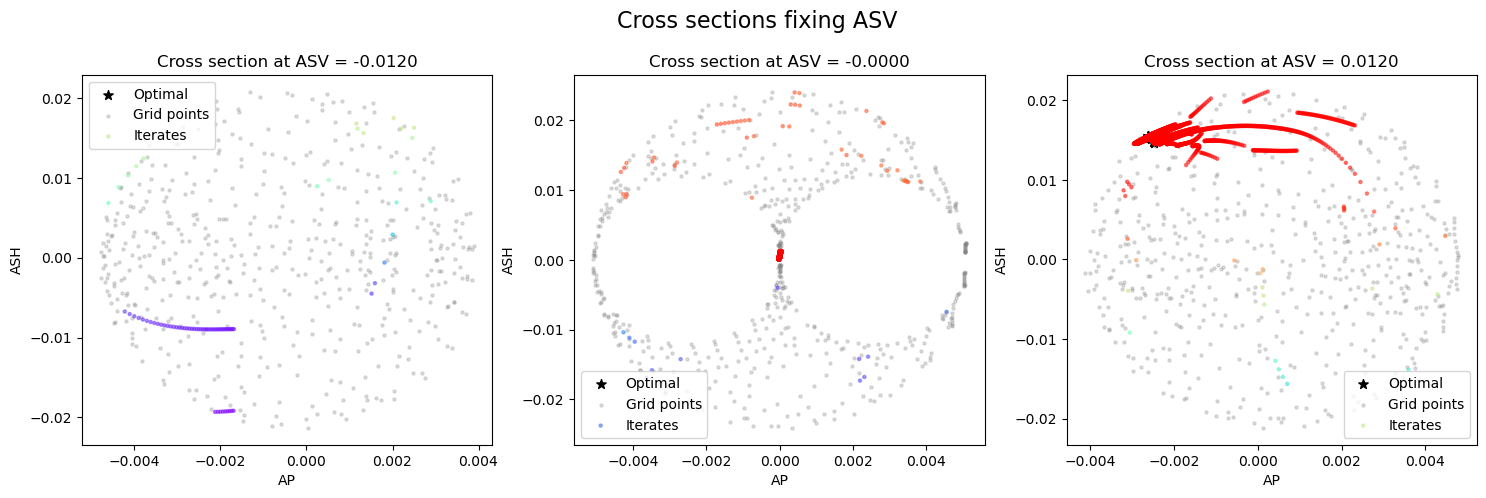

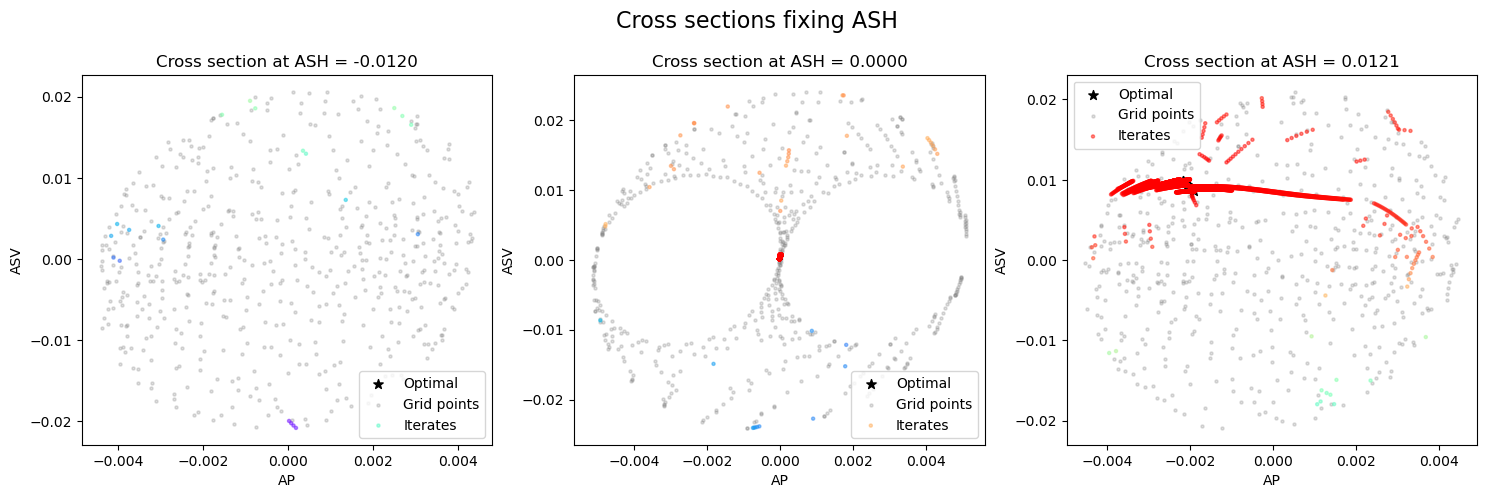

In [7]:
# fix hyperparameters (station location), vary parameters (mechanism)
radiation_model.reset_grid_amplitudes()
radiation_model.set_grid_amplitudes(7, random=False, fix_params=False)
plots.amplitudes(radiation_model, azim=200, elev=30, s=50, alpha=0.5,
                 iterates=True, grid=True, cross_section=[3,3,3],
                 eps_factor=2e-2, optimal=True, observed=True)

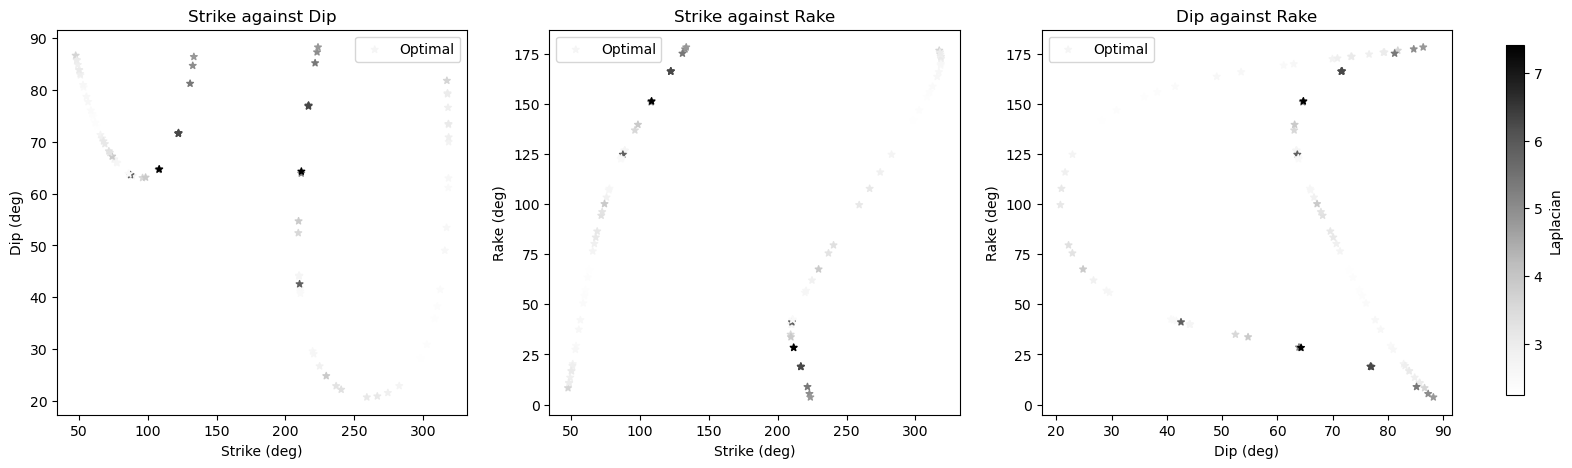

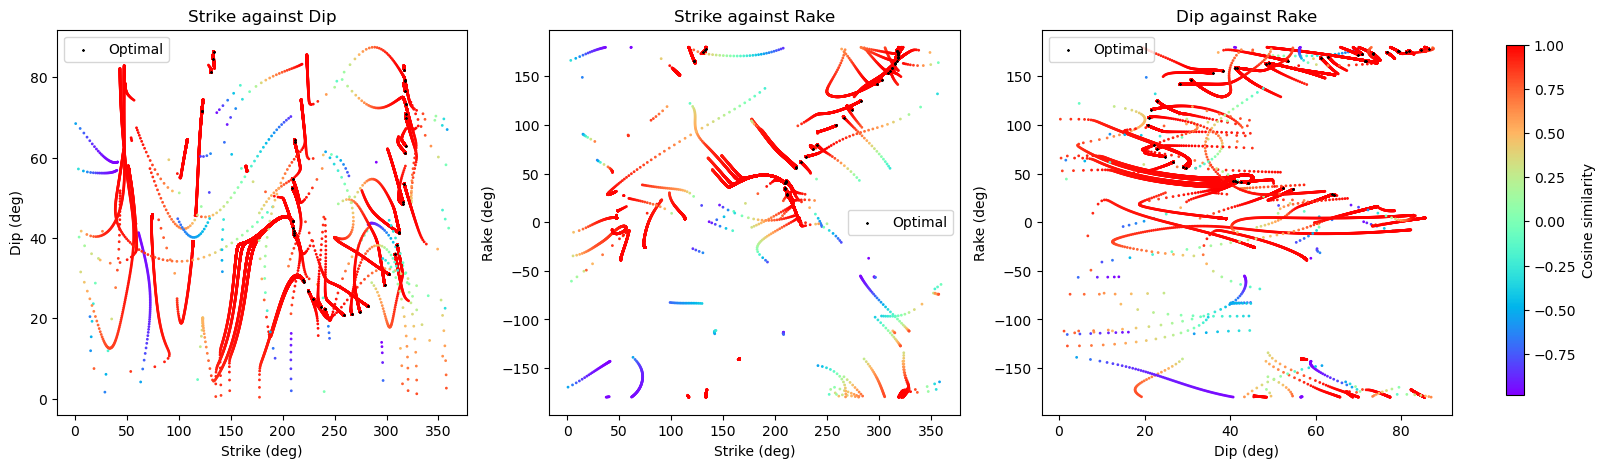

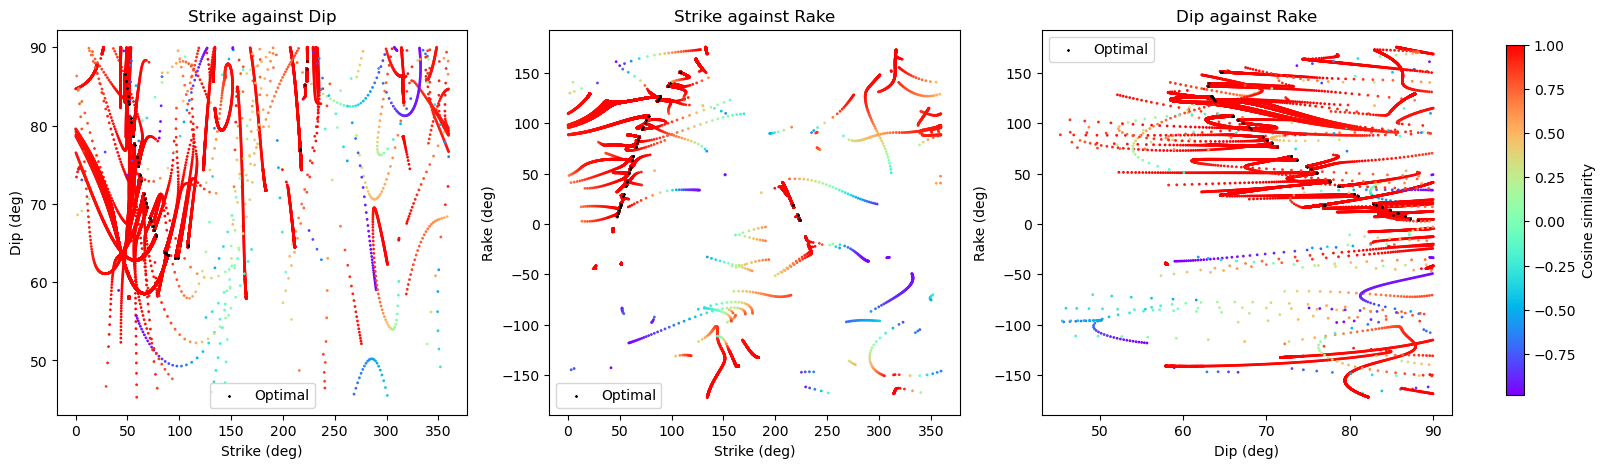

In [8]:
plots.iterates_2D(radiation_model, s=25, optimal=True, index=2, cmap='Greys')

# include iterates per fault plane
plots.iterates_2D(radiation_model, s=1, optimal=False, index=0)
plots.iterates_2D(radiation_model, s=1, optimal=False, index=1)

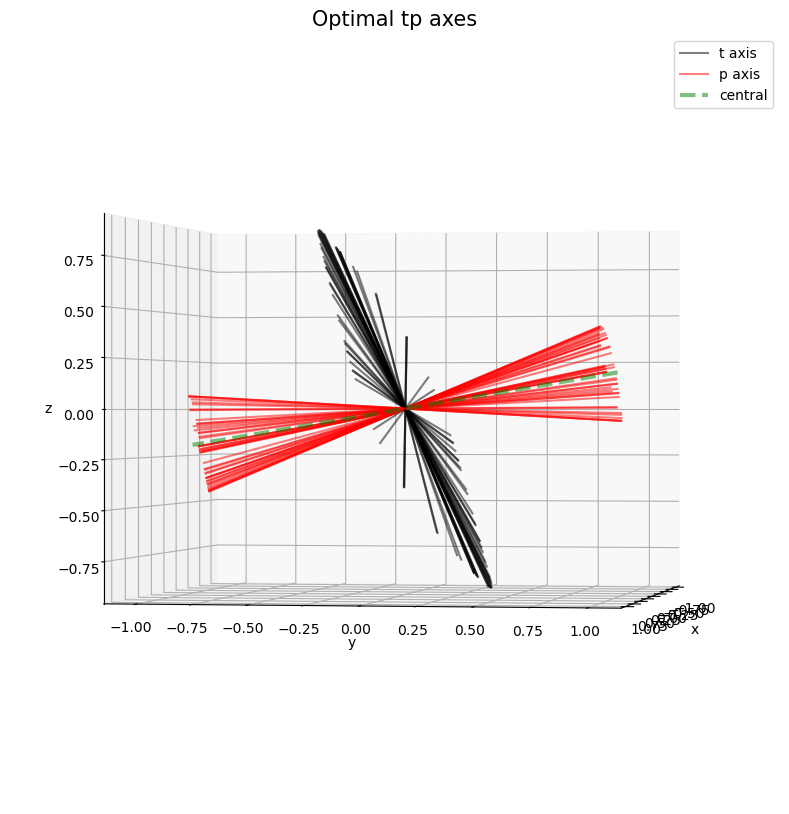

In [9]:
# tp axes, enz coordinates not yet implemented
plots.tp_axes(radiation_model, azim=10, elev=00, half=False, central=False)